# Data Preparation
- Prepare dataset in order to fit the requirements and assumptions for the SMA trading strategy
#### Takeaway:
- Need to create  SMA (2) variables for trading strategy implementation nad test the combinations for statistical relevance

### 1. Import libraries and download dataset

In [53]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_ta as ta
import itertools
from tqdm import tqdm
import multiprocessing

In [75]:
# Read parquet dataframe
def get_df():
    # Read_parquet
    df = pd.read_parquet('raw_data.parquet', engine='pyarrow')
    cols = ['time', 'close']
    df = df[cols]
    
    return df

In [76]:
# Download data
raw_df = get_df()

### 2. Functions
- Set functions for Data cleaning, edition, adding columns, plotting

In [17]:
# Add SMA columns
def calculate_SMA(df, SMA_short, SMA_long):
    # Add date column
    date_column = df['time'].dt.date
    df.insert(loc=1, column='date', value=date_column)
    # Add columns for SMA strategy
    df['SMA_short'] = ta.sma(df['close'],SMA_short)
    df['SMA_long'] = ta.sma(df['close'],SMA_long)
    # Delete rows with NaN values for SMA columns 
    df = df.dropna().reset_index(drop=True)
    
    return df

In [18]:
# Add columns with the closing price in the moment when the BUY or SELL action occur
def add_trade_signals(df):
    # Create columns with BUY and SELL signals
    buy_condition = (df['SMA_short'] >= df['SMA_long']) & (df['SMA_short'].shift(1) < df['SMA_long'].shift(1))
    sell_condition = (df['SMA_short'] < df['SMA_long']) & (df['SMA_short'].shift(1) >= df['SMA_long'].shift(1))

    df['signals_buy'] = df.loc[buy_condition, 'close']
    df['signals_sell'] = df.loc[sell_condition, 'close']

    return df

In [23]:
# Prepare data for SMA strategy
def SMA_data(df, SMA_short, SMA_long, start_date, end_date):
    # Add SMA columns
    df = calculate_SMA(df, SMA_short, SMA_long)
    # Add columns for BUY/SELL signals
    df = add_trade_signals(df)
    # Filter data by date
    df = df.loc[(df['date'] >= pd.to_datetime(start_date).date()) & (df['date'] <= pd.to_datetime(end_date).date())]
    
    return df

In [25]:
# Plot with of closing prices with BUY/SELL signals marked
def plot_SMA(data, SMA_short, SMA_long, start_date, end_date):  # both dates need to be entered in a yyyy-mm-dd format

    # Plot
    fig, ax = plt.subplots(figsize=(26,12))
    ax.plot(data['time'], data['close'], label = 'BTC/BUSD' ,linewidth=1 ,color='blue', alpha = 0.9)
    ax.plot(data['time'], data['SMA_short'], label = f'SMA{SMA_short}', linewidth=1, alpha = 0.85)
    ax.plot(data['time'], data['SMA_long'], label = f'SMA{SMA_long}', linewidth=1,  alpha = 0.85)
    ax.scatter(data['time'], data['signals_buy'] , label = 'Buy' , marker = '^', color = 'green', alpha=1, linewidths=5)
    ax.scatter(data['time'], data['signals_sell'] , label = 'Sell' , marker = 'v', color = 'red', alpha=1, linewidths=5)
    ax.set_title(f'BTC/BUSD - Price History with buy and sell signals ({start_date} - {end_date})',fontsize=20)
    ax.set_xlabel('Time' ,fontsize=18)
    ax.set_ylabel('Close Price INR (₨)' , fontsize=18)
    ax.legend()
    ax.grid()
    plt.tight_layout()
    plt.show()

In [31]:
# Create evaluation metrics for differnt lengths of SMAs
def evaluate_signals(df):
    # Drop null values from 
    signals_buy = df["signals_buy"].dropna()
    signals_sell = df["signals_sell"].dropna()
    # Return evaluation metrics
    return {
        "average_profit_multiplier": signals_sell.mean() / signals_buy.mean(),
        "buy_sell_trade_pair_count": (signals_buy.count() + signals_sell.count()) / 2,
        "overall_profit_multiplier": (signals_sell.mean() / signals_buy.mean() - 1) * (signals_buy.count() + signals_sell.count()) / 2 + 1
    }

In [115]:
# Calculate results for simmulation

def calculate_result(sma_pair):
    # Unpack lengths of SMAs
    SMA_short, SMA_long = sma_pair
    # Create temporary copy for raw dataframe
    raw_data = get_df()
    # Unpack BUY/SELL signals
    df = add_trade_signals(calculate_SMA(raw_data, SMA_short, SMA_long))
    
    results = {
        "SMA_short": SMA_short,
        "SMA_long": SMA_long
    }
    
    results.update(evaluate_signals(df))
    
    return results

### 3. Analysis
- The goal is to find the most optimal values for the short and long SMA in order to maximize the in plus difference for preceding BUY/SELL  signal pairs 
https://www.investopedia.com/articles/active-trading/010116/perfect-moving-averages-day-trading.asp
https://www.investopedia.com/terms/g/goldencross.asp
https://www.babypips.com/learn/forex/moving-average-crossover-trading
---
- We will start with the combination of 5 time lags for short SMA and 13 time lags for long SMA (as in the article attached above), later on possible implementation of simmulation for both SMA length optimization

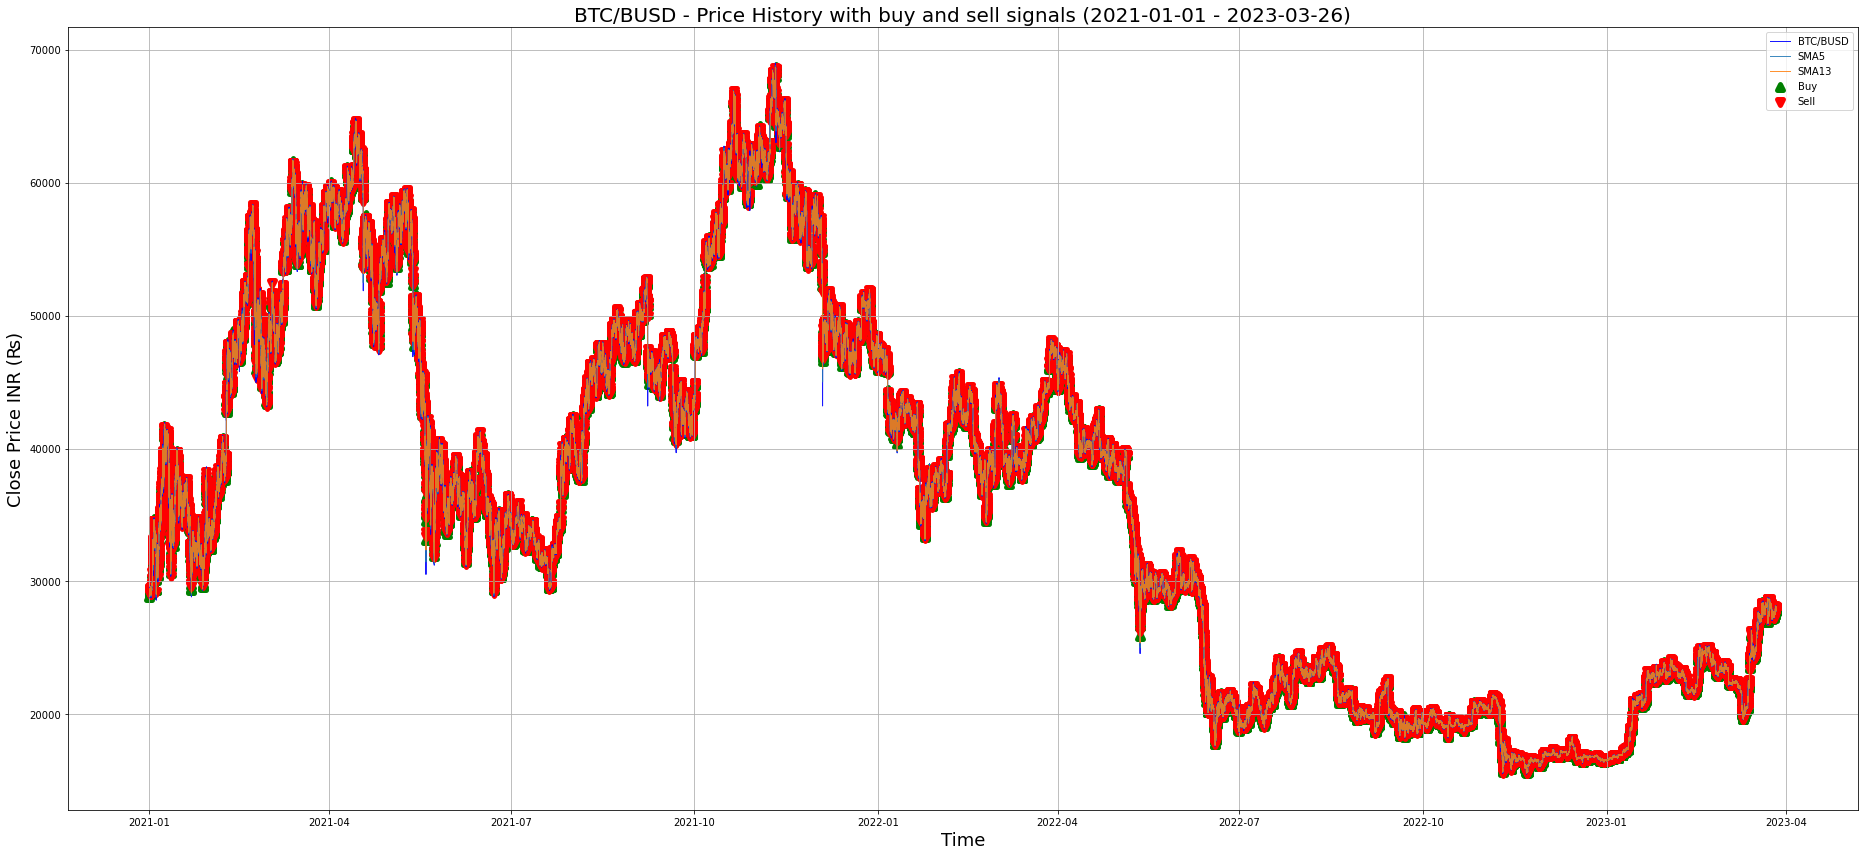

{'average_profit_multiplier': 0.9999609699266787, 'buy_sell_trade_pair_count': 52785.0, 'overall_profit_multiplier': -1.0602024202642366}


In [82]:
# Plot the signals and SMAs for the full period

# Create a temporary copy of raw dataset
copy = raw_df.copy()
# Filter only columns needed for further analysis
copy = copy.loc[:,['time', 'close']]
# SMAs lengths
SMA_short = 5
SMA_long = 13
# Dates for studied period
start_date = '2021-01-01'
end_date = '2023-03-26'
# Preprocess raw data
SMA_df = SMA_data(copy, SMA_short, SMA_long, start_date, end_date)
# Plot signals and SMAs
plot_SMA(SMA_df, SMA_short, SMA_long, start_date, end_date)

# Evaluate trading strategy

# Filter needed columns
evaluation_df = SMA_df.copy().loc[:,['signals_buy', 'signals_sell']]
# Calculate evaluation metrics
print(evaluate_signals(evaluation_df))

#### Takeaway:
- By just looking at the plot we can see that it consists of a couple of middle-ranged trends (both increasing and decresing), overall trend is decreseing
---
- As we are studying the 1m interval data, we need to focus on shorter perspective, we need to take a closer look at the shorter periods
---
- Need to determine when the strategy works and point out when it doesnt, that way we will be able to better develop the forecasting model

#### Takeaway:
- At the first glance obtained statistics show inefficiency in the planned strategy
---
- This particular set of SMAs lengths do not allow to obtain gains
---
- This means it is needed to verify when the planned strategy works well and when not 


### 3. Scenarios simmulation
- One of the posssible approches is to calculate evaluation metrics on different combinations of lengths for short and long SMAs
---
- The main goal is to be able to participate efficiently in a high frequency trading market, therefore we need to assume constraints for the length of both SMAs
---
- We assume the lenghth of range between 2 and 15 for short SMA and range from 8 to 60 for long SMA, that way we narrow down the options that need to be considered in a similuation and keep the high frequency characteristics of potential actions


In [118]:
# Create lists with ranges of SMAs values for combinations calculation

# Short SMA list
SMA_short_list = list(range(2,16))
# Long SMA list
SMA_long_list = list(range(8,61))
# Calculate all of the combinations
SMA_combinations = list(itertools.product(SMA_short_list, SMA_long_list))
# Exclude pairs with the same lengths
SMA_combinations = [pair for pair in SMA_combinations if pair[0] != pair[1]]

# Run simmulation

# Implement multiprocessing
with multiprocessing.Pool() as pool:
    # Set list for simmulation results
    results_list = []
    for result in tqdm(pool.imap_unordered(calculate_result, SMA_combinations)):
        results_list.append(result)
        print(result)
#results = pd.DataFrame(results_list)

0it [00:07, ?it/s]


KeyboardInterrupt: 

In [117]:

results_list = []
for combination in tqdm(SMA_combinations, total=len(SMA_combinations)):
    result = calculate_result(combination)
    results_list.append(result)


  5%|▌         | 37/734 [00:15<04:53,  2.37it/s]


KeyboardInterrupt: 

In [114]:
nums = list(range(1000))
num_pairs = list(itertools.product(nums, nums))

with multiprocessing.Pool() as pool:
        sums = []
        for result in tqdm(pool.imap_unordered(sum, num_pairs), total=len(num_pairs)):
            sums.append(result)
            
sums

100%|██████████| 1000000/1000000 [00:29<00:00, 33874.96it/s]


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 32,
 33,
 31,
 34,
 35,
 36,
 38,
 39,
 40,
 37,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 73,
 72,
 74,
 76,
 77,
 75,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 87,
 88,
 86,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 105,
 106,
 104,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 135,
 136,
 134,
 137,
 138,
 139,
 140,
 141,
 143,
 142,
 145,
 146,
 147,
 148,
 144,
 149,
 151,
 152,
 153,
 154,
 155,
 156,
 150,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 173,
 172,
 174,
 176,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
